In [1]:
!pip install ensemble_boxes

In [2]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import cv2
import json
import pandas as pd
import glob
import datetime
import numpy as np
from tqdm.auto import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
local_labels = pd.read_csv("/content/drive/MyDrive/100 images data/annotations_train.csv")

In [5]:
local_labels.head()

,image_id,rad_id,class_name,x_min,y_min,x_max,y_max
0,000434271f63a053c4128a0ba6352c7f,R2,No finding,NaN,NaN,NaN,NaN
1,000434271f63a053c4128a0ba6352c7f,R3,No finding,NaN,NaN,NaN,NaN
2,000434271f63a053c4128a0ba6352c7f,R6,No finding,NaN,NaN,NaN,NaN
3,00053190460d56c53cc3e57321387478,R11,No finding,NaN,NaN,NaN,NaN
4,00053190460d56c53cc3e57321387478,R2,No finding,NaN,NaN,NaN,NaN


In [6]:
# Define the complete mapping
class_mapping = {
    "No finding": 14,
    "Infiltration": 6,
    "Lung Opacity": 7,
    "Consolidation": 4,
    "Nodule/Mass": 8,
    "Pulmonary fibrosis": 13,
    "Pleural thickening": 11,
    "Aortic enlargement": 0,
    "Cardiomegaly": 3,
    "ILD": 5,
    "Other lesion": 9,
    "Pleural effusion": 10,
    "Calcification": 2,
    "Enlarged PA": 15,
    "Lung cavity": 16,
    "Atelectasis": 1,
    "Mediastinal shift": 17,
    "Lung cyst": 18
}

# Map the class labels to class IDs
local_labels["class_id"] = local_labels["class_name"].map(class_mapping)

local_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    479 non-null    object 
 1   rad_id      479 non-null    object 
 2   class_name  479 non-null    object 
 3   x_min       274 non-null    float64
 4   y_min       274 non-null    float64
 5   x_max       274 non-null    float64
 6   y_max       274 non-null    float64
 7   class_id    479 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 30.1+ KB


In [7]:
copy_data = local_labels.copy()

In [26]:
copy_data = copy_data[copy_data['class_id'] != 14]

In [9]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.8 MB/s eta 0:00:00


In [10]:

import pydicom
from PIL import Image


# Input and output folder paths
input_folder = "/content/drive/MyDrive/100 images data/images"
output_folder = "/content/drive/MyDrive/100 images data/converted_images1"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)



In [ ]:


def convert_dicom_to_png(dicom_path, output_path, window_center=None, window_width=None):
    dicom = pydicom.dcmread(dicom_path)
    pixel_array = dicom.pixel_array.astype(np.float32)

    # Apply windowing if specified
    if window_center and window_width:
        min_val = window_center - (window_width / 2)
        max_val = window_center + (window_width / 2)
        pixel_array = np.clip(pixel_array, min_val, max_val)
        pixel_array = ((pixel_array - min_val) / (max_val - min_val) * 65535).astype(np.uint16)
    else:
        pixel_array = (pixel_array / np.max(pixel_array) * 65535).astype(np.uint16)

    # Write to PNG with 16-bit depth
    cv2.imwrite(output_path, pixel_array)




In [ ]:
# Process all DICOM files in the input folder
for filename in os.listdir(input_folder):

    if filename.endswith(".dicom"):

        try:
            # Load DICOM file
            dicom_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")

            convert_dicom_to_png(dicom_path, output_path)


        except Exception as e:
            print(f"Failed to convert {filename}: {e}")

In [11]:
local_labels['image_path'] = local_labels['image_id'].map(lambda x:os.path.join('/content/drive/MyDrive/100 images data/converted_images1', str(x)+'.png'))
local_labels.head(5)


,image_id,rad_id,class_name,x_min,y_min,x_max,y_max,class_id,image_path
0,000434271f63a053c4128a0ba6352c7f,R2,No finding,NaN,NaN,NaN,NaN,14,/content/drive/MyDrive/100 images data/convert...
1,000434271f63a053c4128a0ba6352c7f,R3,No finding,NaN,NaN,NaN,NaN,14,/content/drive/MyDrive/100 images data/convert...
2,000434271f63a053c4128a0ba6352c7f,R6,No finding,NaN,NaN,NaN,NaN,14,/content/drive/MyDrive/100 images data/convert...
3,00053190460d56c53cc3e57321387478,R11,No finding,NaN,NaN,NaN,NaN,14,/content/drive/MyDrive/100 images data/convert...
4,00053190460d56c53cc3e57321387478,R2,No finding,NaN,NaN,NaN,NaN,14,/content/drive/MyDrive/100 images data/convert...


In [19]:
import cv2
import matplotlib.pyplot as plt

def plot_img(img, size=(8, 8), is_rgb=True, title="", cmap='gray'):
    """
    Plots a single image with customizable size and title.

    Parameters:
    - img: Image to be displayed.
    - size: Tuple for figure size.
    - is_rgb: Boolean to specify if the image is RGB.
    - title: Title for the plot.
    - cmap: Colormap for the plot.
    """
    plt.figure(figsize=size)
    if is_rgb:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()


def plot_imgs(imgs, cols=2, size=5, is_rgb=True, title="", cmap='gray', img_size=None):
    """
    Plots multiple images in a grid.

    Parameters:
    - imgs: List of images.
    - cols: Number of columns.
    - size: Size of each subplot.
    - is_rgb: Boolean to specify if the images are RGB.
    - title: Title for the entire plot.
    - cmap: Colormap for the plot.
    - img_size: Desired size for resizing images.
    """
    rows = len(imgs) // cols + (len(imgs) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * size, rows * size))
    axes = axes.flatten()

    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        if is_rgb:
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            axes[i].imshow(img, cmap=cmap)
        axes[i].axis('off')

    for j in range(len(imgs), len(axes)):
        axes[j].axis('off')  # Hide unused subplots

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


def draw_bbox(image, box, label, color, thickness=2, font_scale=1.0):
    """
    Draws a bounding box with a label on an image.

    Parameters:
    - image: The image to draw on.
    - box: List or tuple [x_min, y_min, x_max, y_max].
    - label: Text label for the box.
    - color: Color of the box and label background.
    - thickness: Thickness of the bounding box lines.
    - font_scale: Scale for the label text.

    Returns:
    - output: Image with the bounding box and label.
    """
    output = image.copy()

    # Draw the bounding box (only the border)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]), color, thickness)

    # Draw the label background
    label_size, _ = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_scale, 2)
    label_width, label_height = label_size
    label_bg_start = (box[0], box[1] - label_height - 5)
    label_bg_end = (box[0] + label_width + 10, box[1])
    cv2.rectangle(output, label_bg_start, label_bg_end, color, -1)

    # Add the label text
    label_pos = (box[0] + 5, box[1] - 5)
    cv2.putText(output, label.upper(), label_pos, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), 2, cv2.LINE_AA)

    return output


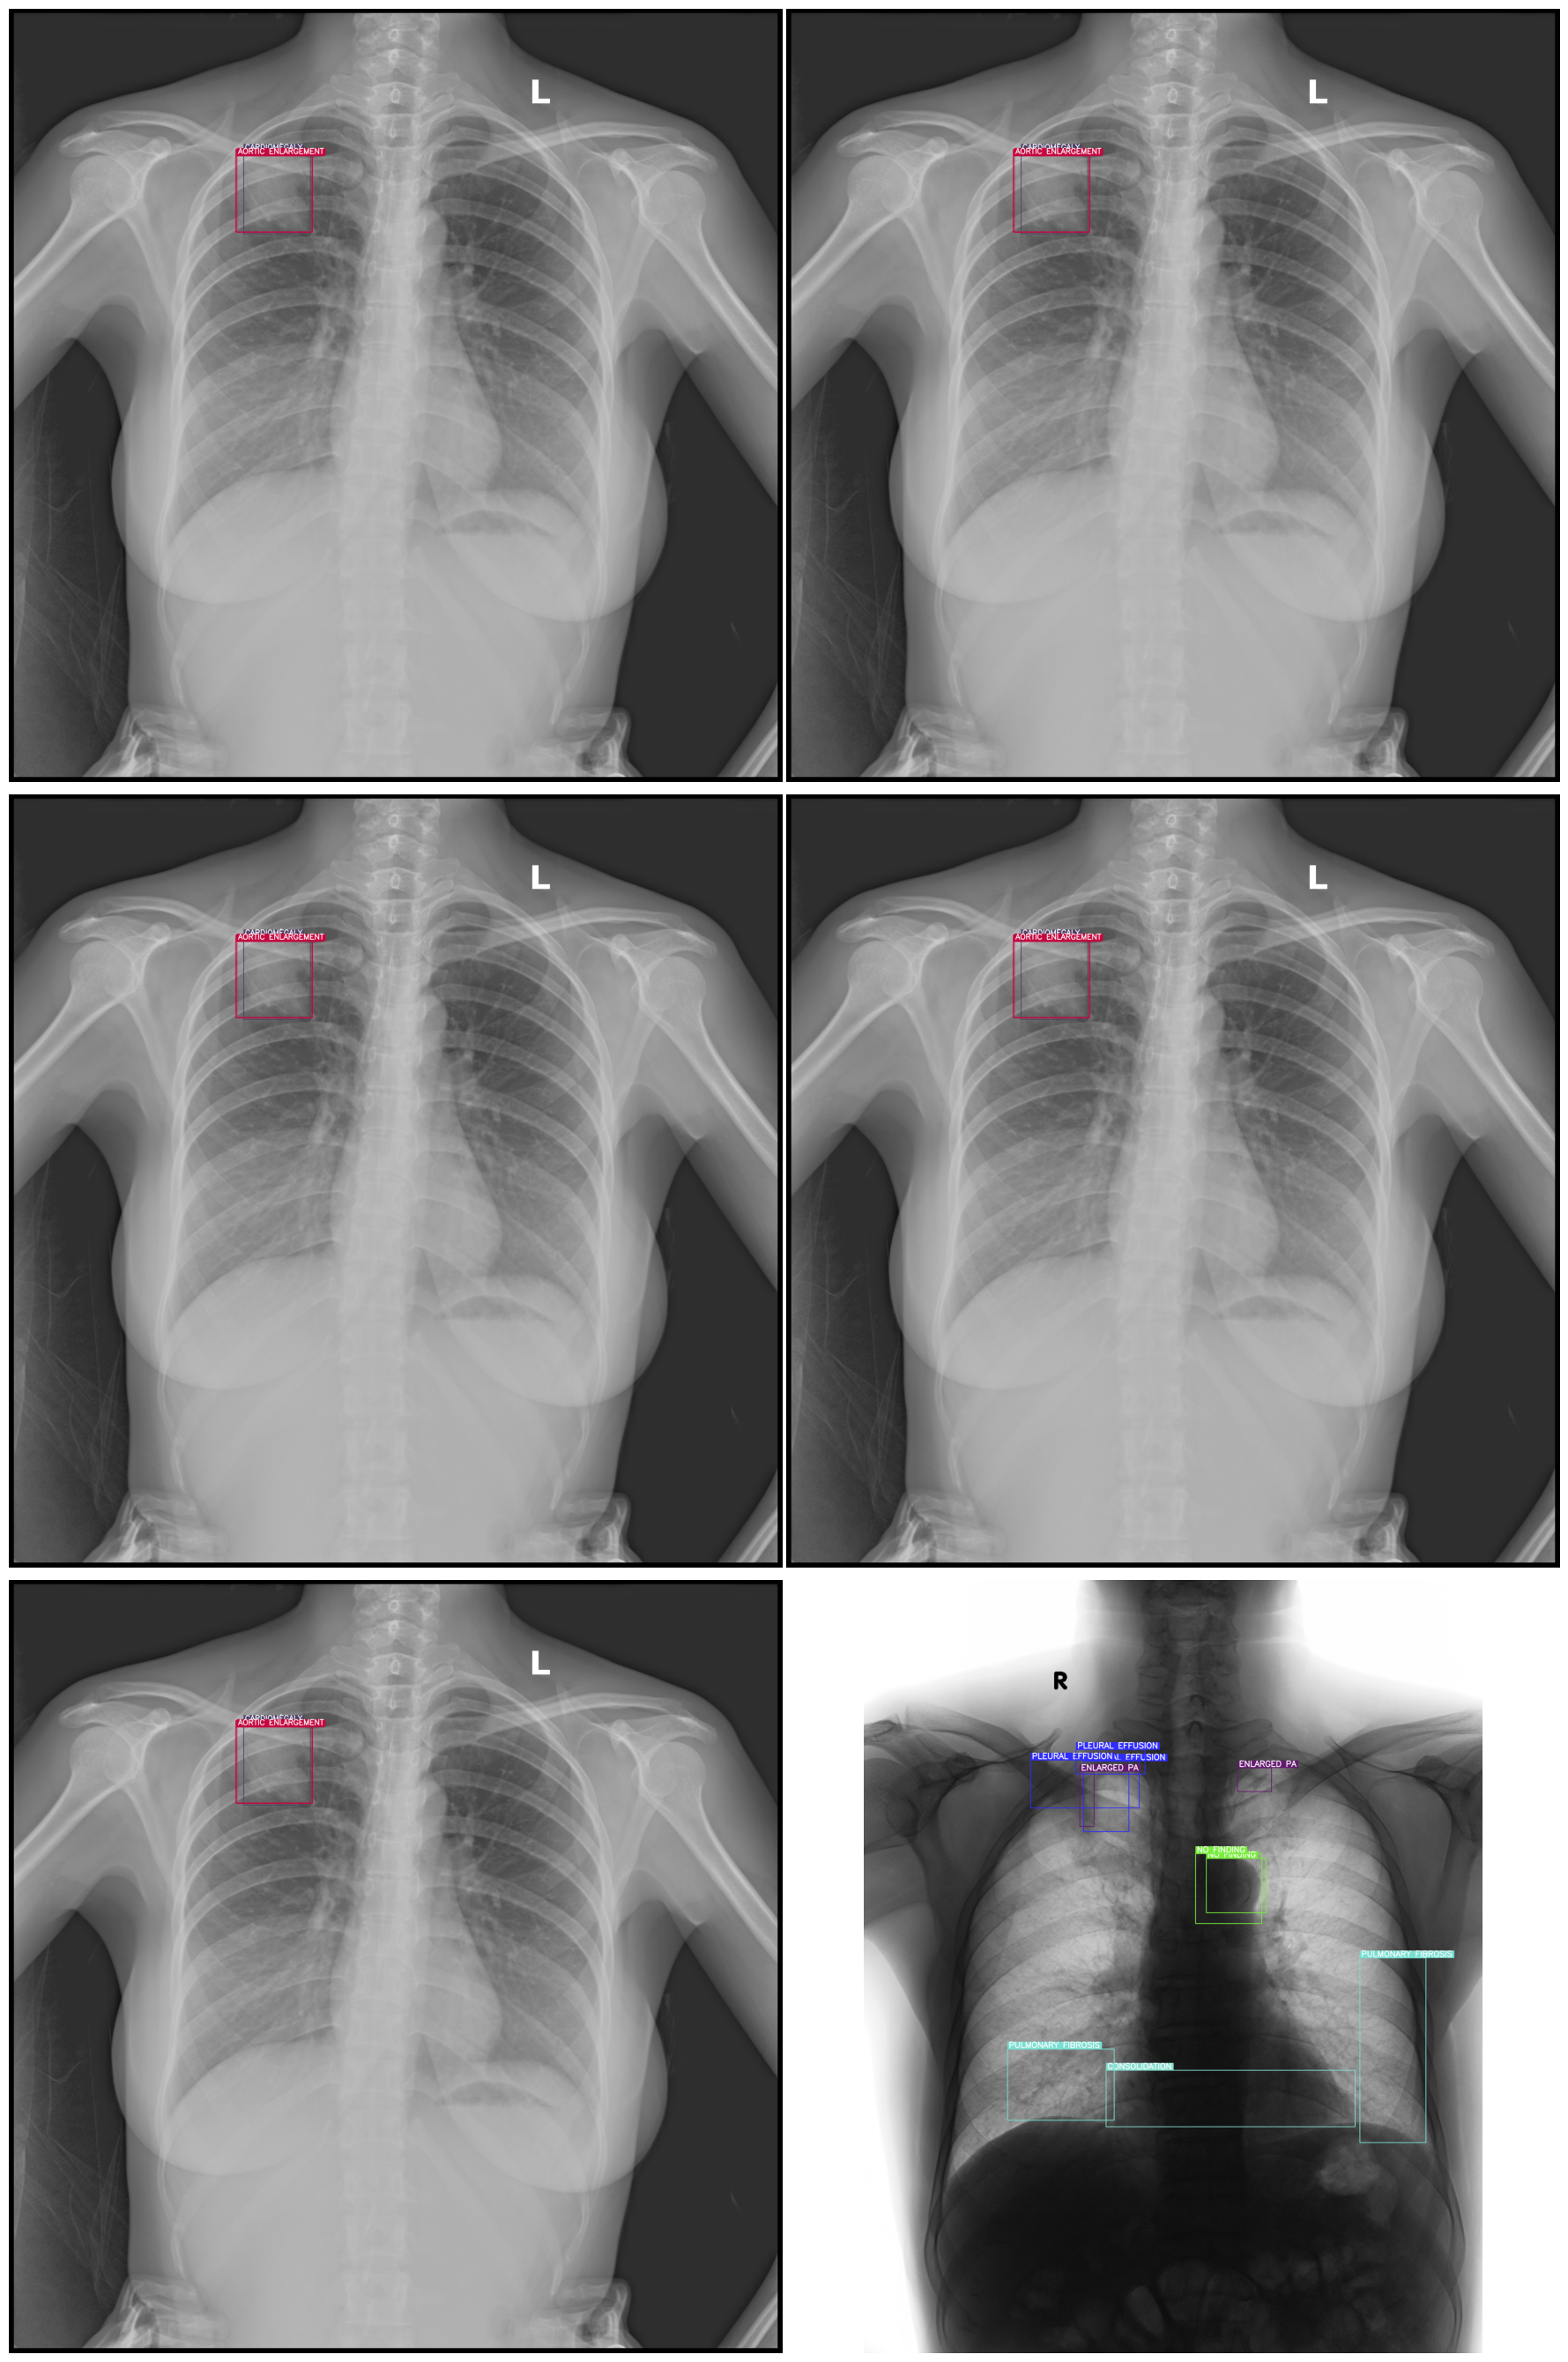

In [20]:
# Ensure viz_labels is defined
viz_labels = [
    "No finding", "Infiltration", "Lung Opacity", "Consolidation", "Nodule/Mass",
    "Pulmonary fibrosis", "Pleural thickening", "Aortic enlargement", "Cardiomegaly",
    "ILD", "Other lesion", "Pleural effusion", "Calcification", "Enlarged PA",
    "Lung cavity", "Atelectasis", "Mediastinal shift", "Lung cyst"
]

# Mapping label_id to color
label2color = [
    [59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
    [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
    [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]
]

thickness = 3
imgs = []

# Ensure the labels with bounding boxes are not empty
valid_data = local_labels.dropna(subset=['x_min', 'y_min', 'x_max', 'y_max'])

# Loop through the first 6 images
for img_id, path in zip(valid_data['image_id'][:6], valid_data['image_path'][:6]):
    # Extract bounding boxes and class IDs
    boxes = valid_data.loc[valid_data['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    img_labels = valid_data.loc[valid_data['image_id'] == img_id, ['class_id']].values.squeeze()

    # Load image
    img = cv2.imread(path)
    if img is None:
        print(f"Could not load image at path: {path}. Skipping...")
        continue

    # Annotate bounding boxes on the image
    for label_id, box in zip(img_labels, boxes):
        if label_id < len(label2color):  # Ensure label_id is valid
            color = label2color[label_id]
            label_name = viz_labels[label_id] if label_id < len(viz_labels) else "Unknown"
            img = draw_bbox(img, list(map(int, box)), label_name, color)

    imgs.append(img)

# Plot the images
plot_imgs(imgs, size=9, cmap=None)
plt.show()


In [21]:

!pip install torch torchvision
!pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.3/111.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f5

In [22]:
!pip install path

In [23]:
from path import Path

In [28]:
copy_data.head()

,image_id,rad_id,class_name,x_min,y_min,x_max,y_max,class_id
6,0005e8e3701dfb1dd93d53e2ff537b6e,R10,Infiltration,900.956970,587.809021,1205.359985,888.710998,6
7,0005e8e3701dfb1dd93d53e2ff537b6e,R10,Lung Opacity,900.956970,587.809021,1205.359985,888.710998,7
8,0005e8e3701dfb1dd93d53e2ff537b6e,R8,Consolidation,932.471985,567.778992,1197.770020,896.408997,4
9,0005e8e3701dfb1dd93d53e2ff537b6e,R8,Nodule/Mass,932.471985,567.778992,1197.770020,896.408997,8
10,0005e8e3701dfb1dd93d53e2ff537b6e,R9,Lung Opacity,905.224976,583.223999,1203.270020,890.148010,7


In [29]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

imagepaths = local_labels['image_path'].unique()

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = local_labels[local_labels.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()

    print("Bboxes before WBF:\n", boxes_viz)
    print("Labels before WBF:\n", viz_labels)

    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)

    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []

    boxes_single = []
    labels_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)


    # Perform WBF
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)


    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)

    print("Bboxes after WBF:\n", boxes)
    print("Labels after WBF:\n", box_labels)

    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()

plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.savefig('wbf.png', bbox_inches='tight')
plt.show()

0it [00:00, ?it/s]

('000ae00eb3942d27e0b97903dd563a6e', '/content/drive/MyDrive/100 images data/converted_images1/000ae00eb3942d27e0b97903dd563a6e.png')
Bboxes before WBF:
 [[nan, nan, nan, nan], [nan, nan, nan, nan], [nan, nan, nan, nan]]
Labels before WBF:
 ['No finding', 'Infiltration', 'Lung Opacity', 'Consolidation', 'Nodule/Mass', 'Pulmonary fibrosis', 'Pleural thickening', 'Aortic enlargement', 'Cardiomegaly', 'ILD', 'Other lesion', 'Pleural effusion', 'Calcification', 'Enlarged PA', 'Lung cavity', 'Atelectasis', 'Mediastinal shift', 'Lung cyst']


IndexError: list index out of range

In [22]:
print(box_labels)

[2, 13, 13, 8, 0]


0it [00:00, ?it/s]

('0021df30f3fddef551eb3df4354b1d06', '/content/drive/MyDrive/100 images data/converted_images/0021df30f3fddef551eb3df4354b1d06.png')
Bboxes before nms:
 [[2259.040039, 1735.819946, 2366.709961, 1853.650024], [812.5960083, 1705.349976, 920.2659912, 1808.959961]]
Labels before nms:
 [8, 8]
Counter({8: 2})
Bboxes after nms:
 [[812.6, 1705.3, 920.3, 1809.0], [2259.0, 1735.8, 2366.7, 1853.7]]
Labels after nms:
 [8, 8]

('0046f681f078851293c4e710c4466058', '/content/drive/MyDrive/100 images data/converted_images/0046f681f078851293c4e710c4466058.png')
Bboxes before nms:
 [[1332.160034, 567.367981, 1773.140015, 1126.300049], [1024.51001, 681.3330078, 1362.859985, 969.9959717], [412.7739868, 594.5189819, 737.6060181, 982.8649902], [1545.910034, 417.5809937, 1809.359985, 688.5529785], [1307.560059, 593.2109985, 1829.430054, 1187.839966], [316.5020142, 553.0670166, 873.5, 1130.140015], [478.4880066, 398.8420105, 709.4069824, 570.1069946], [1326.150024, 477.2250061, 1835.849976, 1108.689941], [315

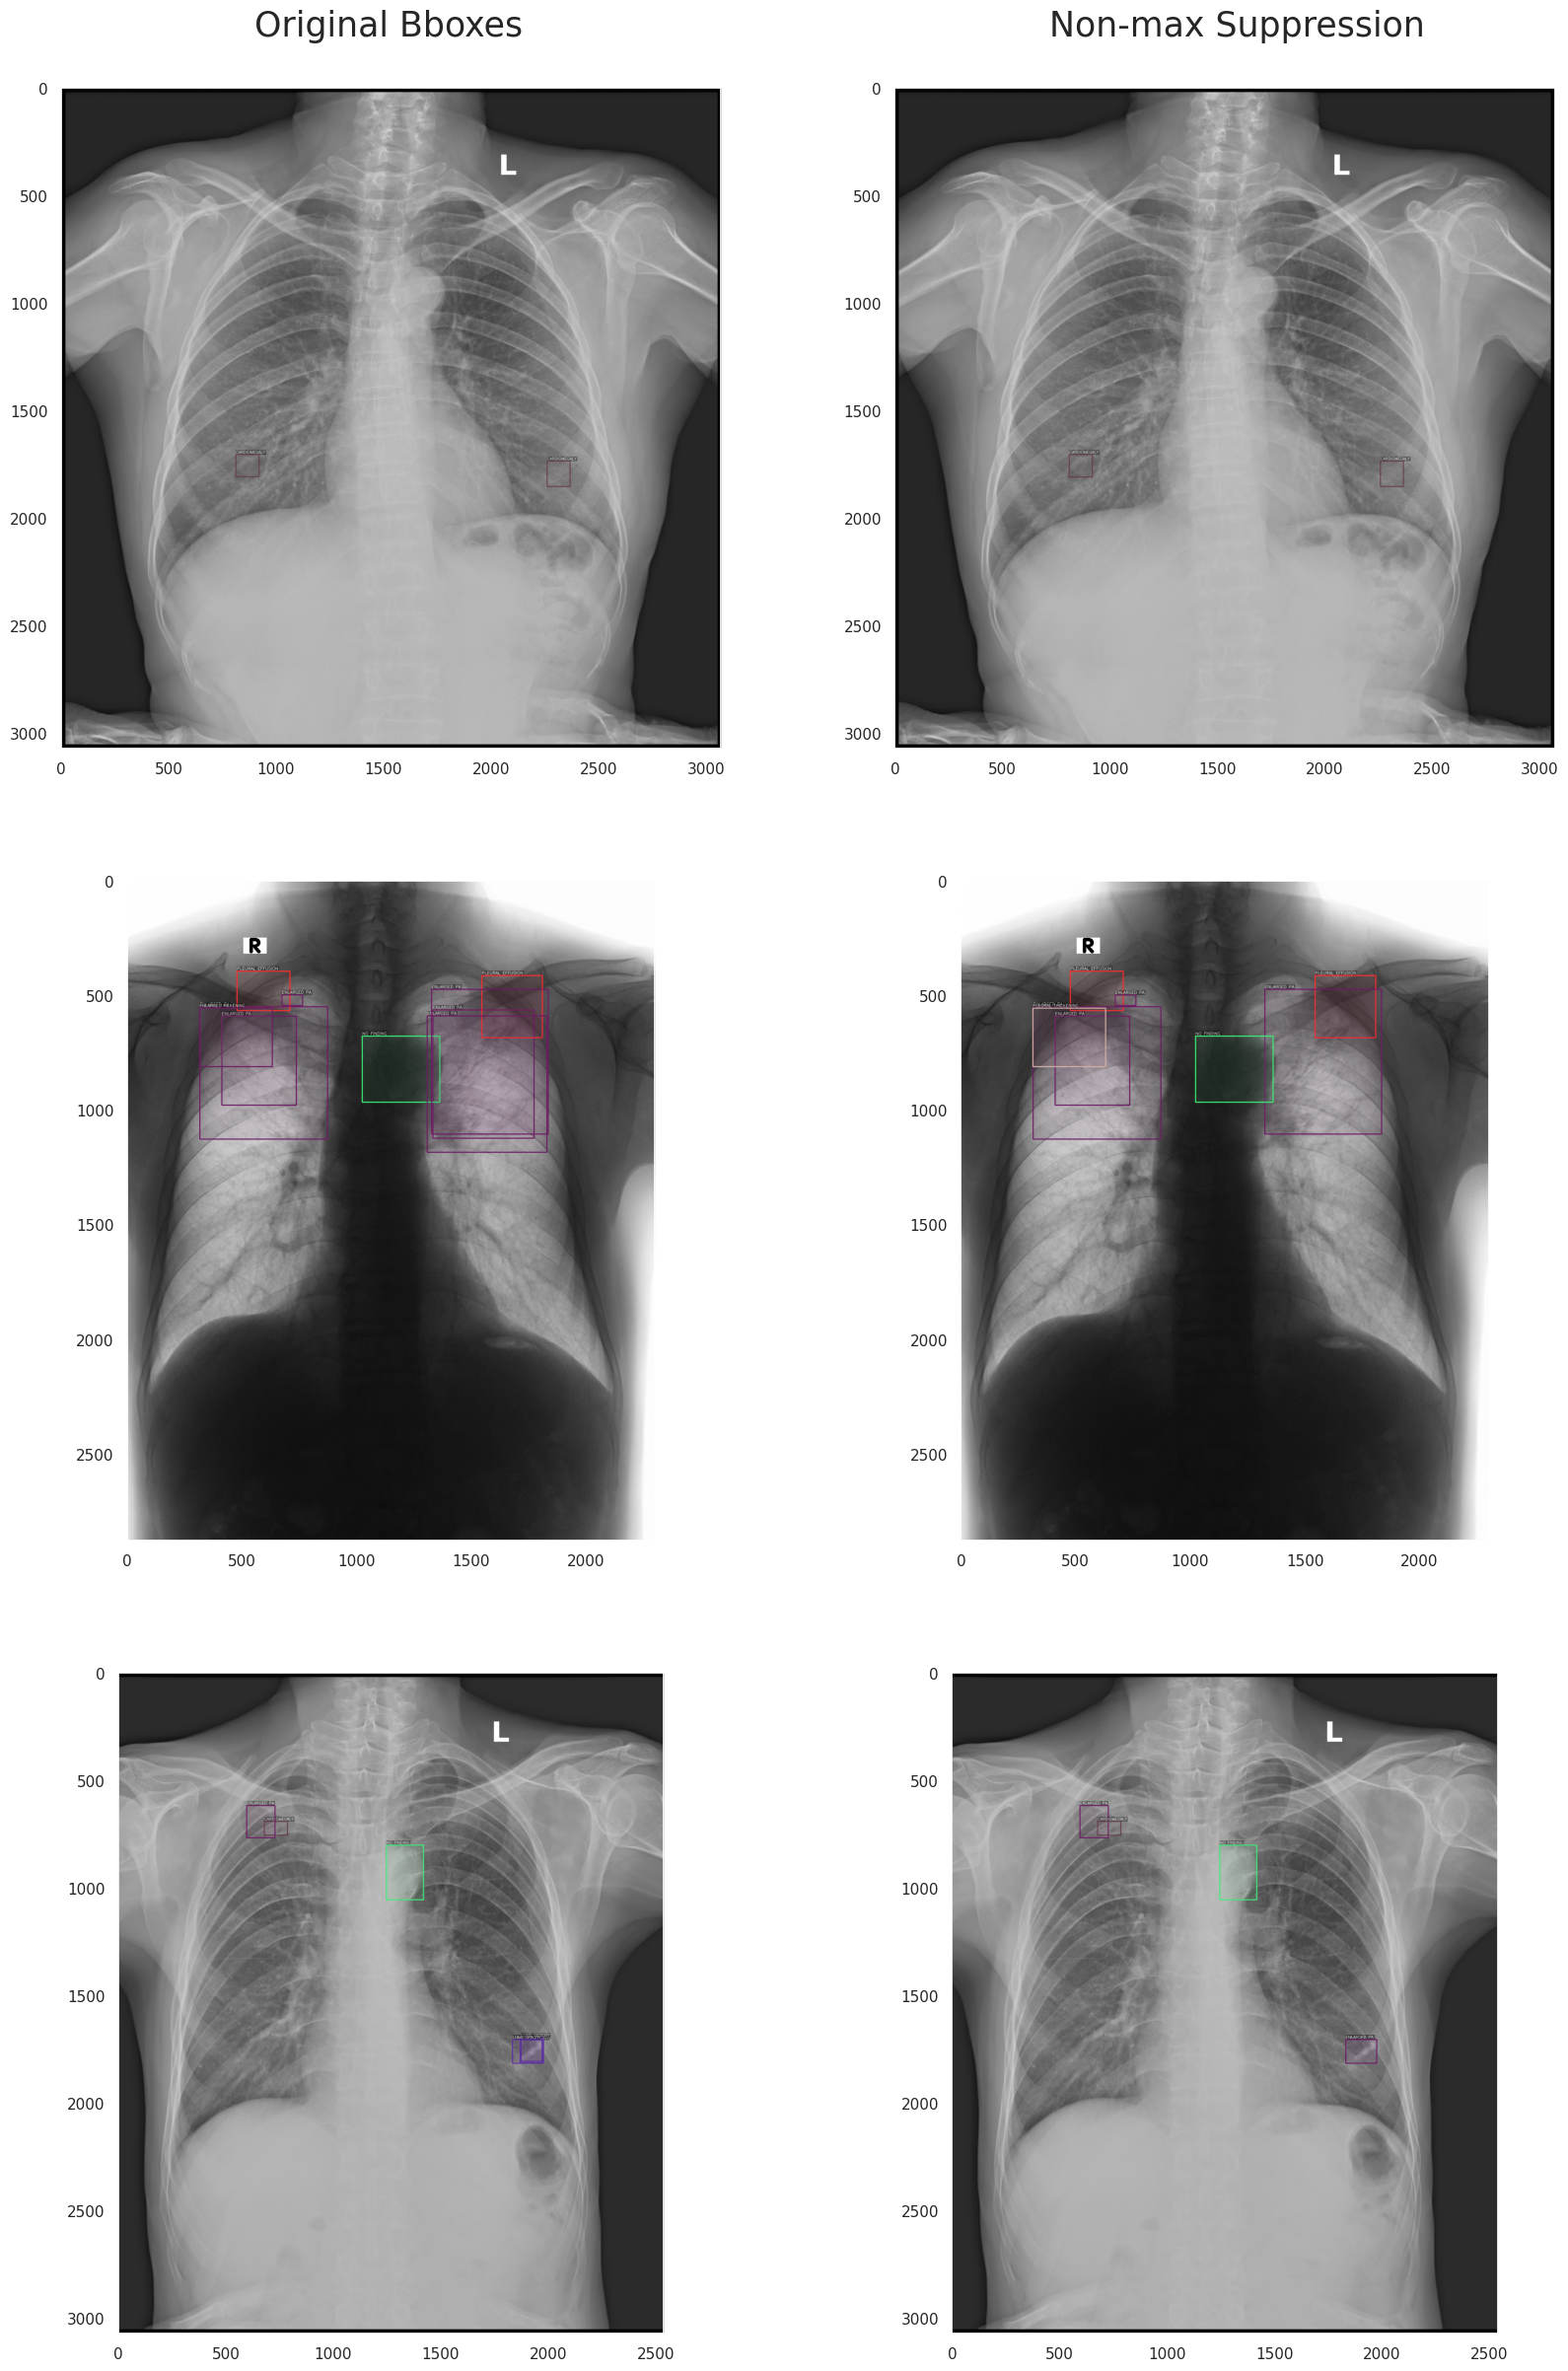

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = copy_data[copy_data.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()

    print("Bboxes before nms:\n", boxes_viz)
    print("Labels before nms:\n", labels_viz)

    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)

    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []

    boxes_single = []
    labels_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)

    # Perform NMS
    boxes, scores, box_labels = nms(boxes_list, scores_list, labels_list, weights=weights,
                                    iou_thr=iou_thr)

    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)

    print("Bboxes after nms:\n", boxes)
    print("Labels after nms:\n", box_labels)

    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()

plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-max Suppression", va="top", ha="center", size=25)
plt.savefig('nms.png', bbox_inches='tight')
plt.show()

In [43]:

# WBF Function
def perform_wbf(img_annotations, img_shape, iou_thr=0.5, skip_box_thr=0.0001, sigma=0.1):
    """
    Perform Weighted Boxes Fusion (WBF) on annotations of an image.

    Parameters:
    - img_annotations: DataFrame with annotations for one image.
    - img_shape: Shape of the image (height, width).
    - iou_thr: IoU threshold for WBF.
    - skip_box_thr: Threshold for skipping boxes with low scores.
    - sigma: Used for Soft-NMS if needed.

    Returns:
    - boxes: Updated bounding boxes after WBF.
    - labels: Corresponding labels of the fused boxes.
    """
    if img_annotations.empty:
        return [], []

    boxes_list, scores_list, labels_list, weights = [], [], [], []
    boxes_single, labels_single = [], []

    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())

    for cid in cls_ids:
        if count_dict[cid] == 1:  # Single bbox, no need for fusion
            labels_single.append(cid)
            bbox = img_annotations[img_annotations.class_id == cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            boxes_single.append(bbox.squeeze().tolist())
        else:  # Perform WBF for multiple boxes of the same label
            cls_list = img_annotations[img_annotations.class_id == cid]['class_id'].tolist()
            bbox = img_annotations[img_annotations.class_id == cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

            # Normalize bounding boxes
            bbox = bbox / (img_shape[1], img_shape[0], img_shape[1], img_shape[0])
            bbox = np.clip(bbox, 0, 1)

            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())  # Assuming confidence scores are 1
            labels_list.append(cls_list)
            weights.append(1)  # Equal weight for all annotators

    # Apply Weighted Boxes Fusion
    from ensemble_boxes import weighted_boxes_fusion  # Ensure you install this library

    if boxes_list:
        boxes, scores, box_labels = weighted_boxes_fusion(
            boxes_list, scores_list, labels_list, weights=weights,
            iou_thr=iou_thr, skip_box_thr=skip_box_thr
        )

        # Denormalize bounding boxes
        boxes = boxes * (img_shape[1], img_shape[0], img_shape[1], img_shape[0])
        boxes = boxes.round(1).tolist()
        box_labels = box_labels.astype(int).tolist()
    else:
        boxes, box_labels = [], []

    # Append single boxes to the results
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)

    return boxes, box_labels


# Process Dataset
def process_dataset(copy_data, image_paths, iou_thr=0.5, skip_box_thr=0.0001, sigma=0.1):
    """
    Process the dataset to apply WBF on all images and return updated annotations.

    Parameters:
    - copy_data: DataFrame containing all annotations.
    - image_paths: List of image file paths.
    - iou_thr: IoU threshold for WBF.
    - skip_box_thr: Threshold for skipping boxes with low scores.
    - sigma: Used for Soft-NMS if needed.

    Returns:
    - updated_data: DataFrame with updated bounding box coordinates.
    """
    updated_annotations = []

    for path in tqdm(image_paths, desc="Processing images"):
        img_array = cv2.imread(path)
        img_shape = img_array.shape[:2]  # (height, width)
        image_basename = Path(path).stem

        # Get annotations for the current image
        img_annotations = copy_data[copy_data.image_id == image_basename]

        # Perform WBF
        boxes, labels = perform_wbf(img_annotations, img_shape, iou_thr, skip_box_thr, sigma)

        # Update the annotations
        if boxes:
            for box, label in zip(boxes, labels):
                updated_annotations.append({
                    "image_id": image_basename,
                    "x_min": box[0],
                    "y_min": box[1],
                    "x_max": box[2],
                    "y_max": box[3],
                    "class_id": label,
                    "image_path": path
                })
        else:  # Handle cases with no findings
            updated_annotations.append({
                "image_id": image_basename,
                "x_min": None,
                "y_min": None,
                "x_max": None,
                "y_max": None,
                "class_id": None,
                "image_path": path
            })

    # Return updated DataFrame
    return pd.DataFrame(updated_annotations)


# Main Execution
if __name__ == "__main__":

    # Example usage on a subset of data
    image_paths = local_labels['image_path'].unique()
    updated_data = process_dataset(copy_data, image_paths, iou_thr=0.5, skip_box_thr=0.0001)


Processing images: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [61]:
updated_data.info()
# updated_data['image_id']['class_id'].unique()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    277 non-null    object 
 1   x_min       210 non-null    float64
 2   y_min       210 non-null    float64
 3   x_max       210 non-null    float64
 4   y_max       210 non-null    float64
 5   class_id    210 non-null    float64
 6   image_path  277 non-null    object 
dtypes: float64(5), object(2)
memory usage: 15.3+ KB


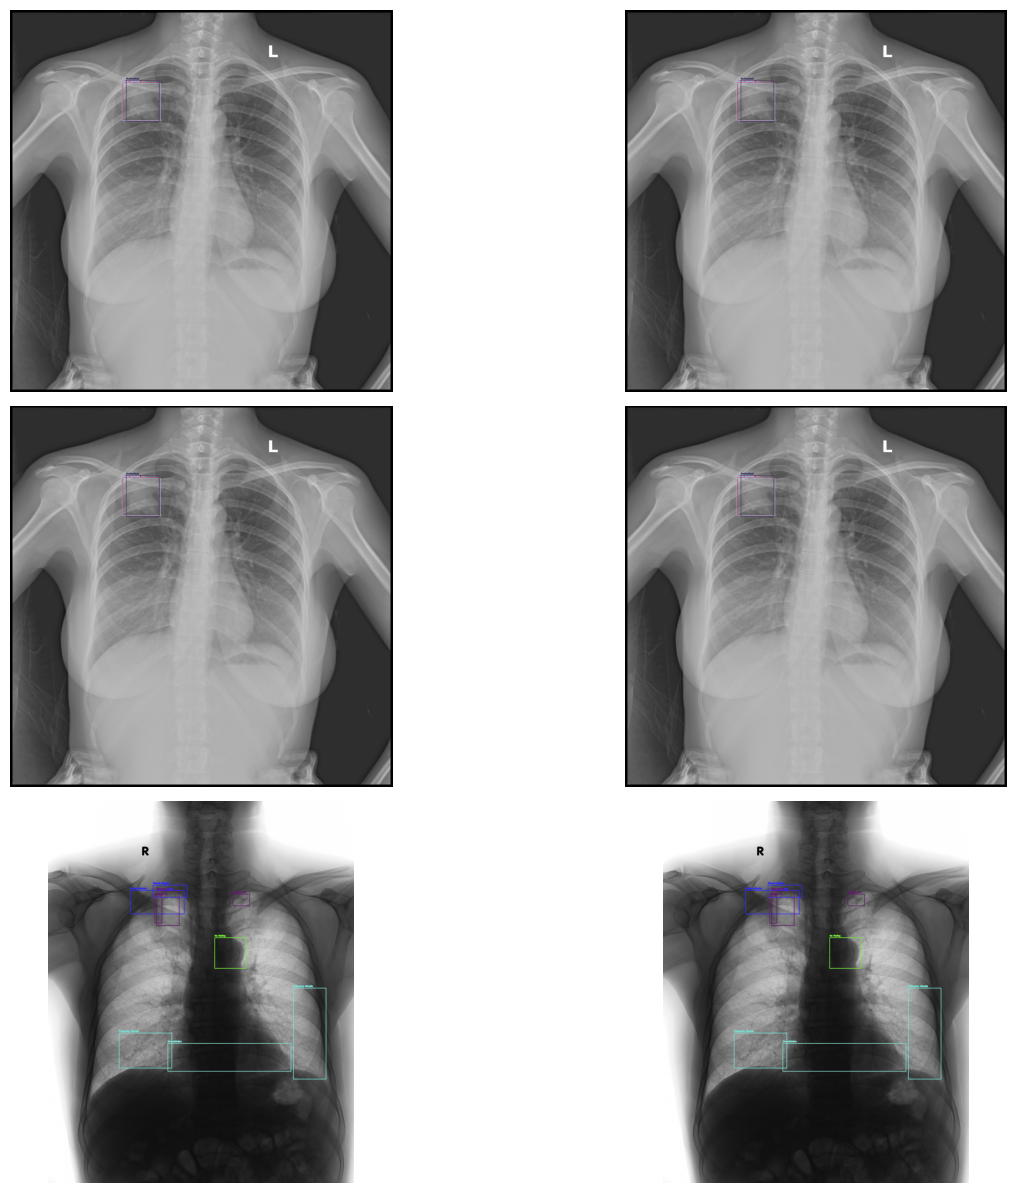

In [52]:
# Filter valid data
valid_data = updated_data.dropna(subset=['x_min', 'y_min', 'x_max', 'y_max'])


# Visualization loop
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 cols
axes = axes.flatten()  # Flatten axes array for easier iteration

for idx, (img_id, path) in enumerate(zip(valid_data['image_id'][:6], valid_data['image_path'][:6])):
    # Extract bounding boxes and class IDs
    boxes = valid_data.loc[valid_data['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    img_labels = valid_data.loc[valid_data['image_id'] == img_id, ['class_id']].values.squeeze()

    # Load image
    img = cv2.imread(path)
    if img is None:
        print(f"Could not load image at path: {path}. Skipping...")
        continue

    # Annotate bounding boxes
    for label_id, box in zip(img_labels, boxes):
        label_id = int(label_id)  # Ensure label_id is an integer
        if label_id < len(label2color):  # Ensure label_id is valid
            color = label2color[label_id]
            label_name = viz_labels[label_id] if label_id < len(viz_labels) else "Unknown"
            img = draw_bbox(img, box, label_name, color, thickness)

    # Convert image from BGR to RGB for visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot on respective subplot
    axes[idx].imshow(img_rgb)
    axes[idx].axis("off")


# Adjust layout and show the plot
plt.tight_layout()
plt.show()